In [ ]:
"""
To see if can build a classifier that identifies cells that 
should have the floating axon rule applied to them, and those that shouldn't


"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import sys
sys.path.append("/meshAfterParty/")

In [3]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import numpy as np

import proofreading_utils as pru

import preprocessing_vp2 as pre

# -- For the axon classification --

import neuron_searching as ns

import skeleton_utils as sk

import numpy_utils as nu

import networkx_utils as xu

import system_utils as su

INFO - 2021-01-29 00:18:41,732 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-29 00:18:41,734 - settings - Setting database.user to celiib
INFO - 2021-01-29 00:18:41,735 - settings - Setting database.password to newceliipass
INFO - 2021-01-29 00:18:41,739 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-29 00:18:41,740 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-29 00:18:41,752 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-29 00:18:42,031 - settings - Setting enable_python_native_blobs to True


In [4]:
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-29 00:18:42,117 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-29 00:18:42,406 - settings - Setting enable_python_native_blobs to True


# Importing the Neuron

In [5]:
(minnie.Decomposition() & "n_limbs>8" & "n_error_limbs=0")

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),multiplicity the number of somas found for this base segment,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691134884741370,0,0.25,30.00,0,0,1,=BLOB=,380482,782797,0,0,0,0,1,9,155,111,4957951.094062191,3258375.4424227052,18747.22,86.29,86.29,304.834,264.235,888,0.0001791062443240916,5.7290322580645165,2182315.787,47,0.000406907197065518,18.894,246174952917.70355,148392566.49754968,49652.55772944815,112804.4595489624,5237764955.69582,2997.7505
864691134884744698,0,0.25,30.00,0,0,1,=BLOB=,304543,628181,0,0,0,0,1,10,45,19,2572240.2636876525,859945.1719564002,47557.428,371.006,303.317,598.593,506.099,1394,0.000541940043346306,30.977777777777778,2502807.014,41,0.0005569746257711263,34.0,245013023955.07565,123742902.31608549,95252.77533904104,97895.29219973476,5975927413.53843,1616.7387
864691134884748026,0,0.25,30.00,0,0,1,=BLOB=,420027,845933,0,0,0,0,1,9,83,29,4264839.614019831,1233064.320639635,34585.162,266.767,240.558,445.096,432.024,1837,0.00043073132081244503,22.132530120481928,3126272.098,52,0.0005876008045413582,35.327,455990220238.503,167251658.6566677,106918.49202008062,145857.49606703073,8769042696.894289,2258.0372
864691134884749306,0,0.25,30.00,0,0,1,=BLOB=,128236,263233,0,0,0,0,1,11,123,69,2825436.2442786554,1960400.1846538119,15389.194,68.438,68.438,151.048,151.048,1,3.5392764640325616e-07,0.008130081300813009,92419.698,14,1.082020415171666e-05,0.071,343257071.9985161,343257071.9985161,121.48816760370784,3714.1115955444484,24518362.28560829,299.2331
864691134884749562,0,0.25,30.00,0,0,1,=BLOB=,601749,1218939,0,0,0,0,1,9,222,81,9300257.982468953,3628687.696599574,27525.157,81.04,81.04,347.243,312.489,1303,0.000140103640399671,5.86936936936937,3473456.532,60,0.00037513064810105416,21.717,153643447566.38287,56863176.80465126,16520.3425384545,44233.588689222976,2560724126.1063814,2454.3775
864691134884751866,0,0.25,30.00,0,0,1,=BLOB=,133028,266987,0,0,0,0,1,12,146,53,3165582.065360753,1534226.1075221612,14816.126,76.707,76.707,160.869,160.869,0,0

In [6]:
segment_id = 864691134884789754

In [7]:
neuron_objs =du.decomposition_with_spine_recalculation(segment_id)
len(neuron_objs)

Decompressing Neuron in minimal output mode...please wait


1

In [9]:
neuron_obj_1 = neuron_objs[0]

In [11]:
import classification_utils as clu

In [12]:
clu.inhibitory_excitatory_classifier(neuron_obj_1)

spine_category = densely_spined


'excitatory'

In [29]:
neuron_obj_1 = neuron_objs[0]
axon_limb_branch_dict,axon_error_limb_branch_dict = clu.axon_classification(neuron_obj_1,
                        return_axon_labels=True,
                        return_error_labels=True,
                       plot_axons=True,
                       plot_axon_errors=True
                       )


Part 1: Axon like branchese 
{'L0': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  99, 100, 101, 102, 104, 105, 106, 108,
       109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 171]), 'L1': array([11, 20, 25]), 'L2': array([ 0,  1,  2


 Working on visualization type: mesh


In [32]:
ns.query_neuron_by_labels(neuron_obj_1,
                         matching_labels=["axon-like"],
                         not_matching_labels=["axon","axon-error"])

{'L2': array([7])}

In [30]:
ns.query_neuron_by_labels(neuron_obj_1,
                         matching_labels=["axon-error"])

{'L1': array([11, 25]),
 'L2': array([ 0,  1,  2,  3,  8,  9, 13, 15, 18, 19, 20, 21, 22, 23, 24]),
 'L3': array([1]),
 'L4': array([3])}

# figuring out how much error limbs there are

In [33]:
removed_limb_branch_dict = nru.limb_branch_after_limb_branch_removal(neuron_obj=neuron_obj_1,
                                      limb_branch_dict = axon_error_limb_branch_dict,
                             return_removed_limb_branch = True,
                            )

In [34]:
total_area = nru.sum_feature_over_limb_branch_dict(neuron_obj_1,
                                       limb_branch_dict=removed_limb_branch_dict,
                                       feature="area")

total_sk_distance = nru.sum_feature_over_limb_branch_dict(neuron_obj_1,
                                       limb_branch_dict=removed_limb_branch_dict,
                                       feature="skeletal_length")/1000

# the data that we will save off for the statistics
total_area,total_sk_distance

(449.10723861508427, 396.22523537217086)

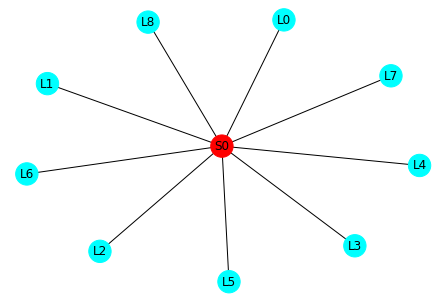

In [35]:
nviz.plot_soma_limb_concept_network(neuron_obj_1)

# Deleting the Error Nodes

In [36]:
import proofreading_utils as pru
    
new_neuron = pru.delete_branches_from_neuron(neuron_obj_1,
                                    limb_branch_dict = removed_limb_branch_dict,
                                    plot_neuron_after_cancellation = False,
                                    plot_final_neuron = True,
                                    verbose = True)

Number of branches at beginning = 252 
---- Working on Limb 1 ----
length of concept network BEFORE elimination = 26 
length of concept network AFTER elimination = 24 


----Working on seperate_graph 0----


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [593801. 582003. 982639.]---------
Starting_edge inside branches_to_conept = [[592680. 566173. 987622.]
 [593801. 582003. 982639.]]
There were 1 duplication nodes found
domination_map = {20: 19}
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [14]
printing out current edge:
[[593801. 582003. 982639.]
 [592680. 566173. 987622.]]
edge_endpoints_to_process was empty so exiting loop after 23 iterations
starting_node in concept map (that should match the starting edge) = 13
Total time for branches to concept conversion = 0.6419956684112549

Working on adding back the edges that were duplicates
Done generating concept network 


---- Working on Limb 2 ----
length of concept networ

In [37]:
leftover_errors = ns.query_neuron_by_labels(new_neuron,matching_labels=["axon-like"],
                         not_matching_labels=["axon"])
leftover_errors

{'L2': array([3])}

In [38]:
file_name = "neuron_phase_1_after_floating_axon"
new_neuron.save_compressed_neuron(file_name,
                                 export_mesh=True)

Saving Neuorn in suppress_output mode...please wait
Saved File at location: neuron_phase_1_after_floating_axon/864691134884789754_0_25_soma_0_split


# Turn the process into a function

In [55]:
pru.filter_away_axon_on_dendrite_merges(
    neuron_obj = neuron_obj_1,
    perform_axon_classification = True,
    return_error_info=True,
    verbose = True)

performing axon classification for axon-error detection

Part 1: Axon like branchese 
{'L0': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  99, 100, 101, 102, 104, 105, 106, 108,
       109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 1

After disconnecte effect, removed_limb_branch_dict = {'L1': [11, 25], 'L2': [0, 1, 2, 3, 8, 9, 13, 15, 18, 19, 20, 21, 22, 23, 24], 'L3': [1], 'L4': [3]}
total_sk_distance = 396.22523537217086, total_area = 449.10723861508427


----Working on seperate_graph 0----


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [593801. 582003. 982639.]---------
Starting_edge inside branches_to_conept = [[592680. 566173. 987622.]
 [593801. 582003. 982639.]]
There were 1 duplication nodes found
domination_map = {20: 19}
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [14]
printing out current edge:
[[593801. 582003. 982639.]
 [592680. 566173. 987622.]]
edge_endpoints_to_process was empty so exiting loop after 23 iterations
starting_node in concept map (that should match the starting edge) = 13
Total time for branches to concept conversion = 0.650047779083252

Working on adding back the edges that were duplicates
Done generating concept networ

(<neuron.Neuron at 0x7f07f61f7898>, 449.10723861508427, 396.22523537217086)

# Development

In [43]:
ns.query_neuron_by_labels(new_neuron,matching_labels=["axon"])

{'L0': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171])}

In [46]:
# def filter_away_limb_branch_dict(neuron_obj,
#                                  limb_branch_dict,
#                                 plot_limb_branch_filter_away=False,
#                                  plot_limb_branch_filter_with_disconnect_effect=False,
#                                 return_error_info=True,
#                                  plot_final_neuron=False,
#                                  verbose=False
#                                 ):
    
#     if plot_limb_branch_filter_away:
#         print("\n\nBranches Requested to Remove (without disconnect effect)")
#         nviz.plot_limb_branch_dict(neuron_obj,
#                              limb_branch_dict)


#     #2) Find the total branches that will be removed using the axon-error limb branch dict

#     removed_limb_branch_dict = nru.limb_branch_after_limb_branch_removal(neuron_obj=neuron_obj,
#                                           limb_branch_dict = limb_branch_dict,
#                                  return_removed_limb_branch = True,
#                                 )

#     if verbose:
#         print(f"After disconnecte effect, removed_limb_branch_dict = {removed_limb_branch_dict}")
        
#     if plot_limb_branch_filter_with_disconnect_effect:
#         print("\n\nBranches Requested to Remove (WITH disconnect effect)")
#         nviz.plot_limb_branch_dict(neuron_obj,
#                              removed_limb_branch_dict)
    
#     #3) Calculate the total skeleton length and error faces area for what will be removed
#     if return_error_info:
#         total_area = nru.sum_feature_over_limb_branch_dict(neuron_obj,
#                                            limb_branch_dict=removed_limb_branch_dict,
#                                            feature="area")

#         total_sk_distance = nru.sum_feature_over_limb_branch_dict(neuron_obj,
#                                                limb_branch_dict=removed_limb_branch_dict,
#                                                feature="skeletal_length")/1000
        
#         if verbose:
#             print(f"total_sk_distance = {total_sk_distance}, total_area = {total_area}")
        
#     #4) Delete the brnaches from the neuron
#     new_neuron = pru.delete_branches_from_neuron(neuron_obj_1,
#                                     limb_branch_dict = removed_limb_branch_dict,
#                                     plot_neuron_after_cancellation = False,
#                                     plot_final_neuron = False,
#                                     verbose = False)

#     if plot_final_neuron:
#         nviz.visualize_neuron(new_neuron,
#                              visualize_type=["mesh"],
#                              mesh_whole_neuron=True)
    
#     if return_error_info:
#         return new_neuron,total_area,total_sk_distance
#     else:
#         return new_neuron

In [51]:
# import copy
# def filter_away_axon_on_dendrite_merges(
#     neuron_obj,
#     perform_deepcopy = True,
    
#     axon_merge_error_limb_branch_dict = None,
#     perform_axon_classification = False,
#     use_pre_existing_axon_error_labels = False,

#     return_error_info=True,

#     plot_limb_branch_filter_away = False,
#     plot_limb_branch_filter_with_disconnect_effect=False,
#     plot_final_neuron = False,

#     verbose = False):

#     """
#     Pseudocode: 

#     If error labels not given
#     1a) Apply axon classification if requested
#     1b) Use the pre-existing error labels if requested

#     2) Find the total branches that will be removed using the axon-error limb branch dict
#     3) Calculate the total skeleton length and error faces area for what will be removed
#     4) Delete the brnaches from the neuron
#     5) Return the neuron


#     """
#     if perform_deepcopy:
#         neuron_obj = copy.deepcopy(neuron_obj)

#     if axon_merge_error_limb_branch_dict is None:
#         if perform_axon_classification == False and use_pre_existing_axon_error_labels == False:
#             raise Exception("Need to set either perform_axon_classification or use_pre_existing_axon_error_labels because"
#                            f" axon_merge_error_limb_branch_dict is None")

#         if use_pre_existing_axon_error_labels:

#             if verbose:
#                 print("using pre-existing labels for axon-error detection")

#             axon_merge_error_limb_branch_dict = ns.query_neuron_by_labels(neuron_obj,matching_labels=["axon-error"])
#         else:

#             if verbose:
#                 print("performing axon classification for axon-error detection")


#             axon_limb_branch_dict,axon_merge_error_limb_branch_dict = clu.axon_classification(neuron_obj_1,
#                             return_axon_labels=True,
#                             return_error_labels=True,
#                            plot_axons=False,
#                            plot_axon_errors=False,
#                             verbose=True,
#                            )


#     new_neuron,total_area,total_sk_distance = filter_away_limb_branch_dict(neuron_obj,
#                                      limb_branch_dict=axon_merge_error_limb_branch_dict,
#                                     plot_limb_branch_filter_away=plot_limb_branch_filter_away,
#                                      plot_limb_branch_filter_with_disconnect_effect=plot_limb_branch_filter_with_disconnect_effect,
#                                     return_error_info=return_error_info,
#                                      plot_final_neuron=plot_final_neuron,
#                                      verbose=verbose
#                                     )
#     return new_neuron,total_area,total_sk_distance

        


using performing axon classification for axon-error detection

Part 1: Axon like branchese 
{'L0': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  99, 100, 101, 102, 104, 105, 106, 108,
       109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 

After disconnecte effect, removed_limb_branch_dict = {'L1': [11, 25], 'L2': [0, 1, 2, 3, 8, 9, 13, 15, 18, 19, 20, 21, 22, 23, 24], 'L3': [1], 'L4': [3]}
total_sk_distance = 396.22523537217086, total_area = 449.10723861508427


----Working on seperate_graph 0----


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [593801. 582003. 982639.]---------
Starting_edge inside branches_to_conept = [[592680. 566173. 987622.]
 [593801. 582003. 982639.]]
There were 1 duplication nodes found
domination_map = {20: 19}
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [14]
printing out current edge:
[[593801. 582003. 982639.]
 [592680. 566173. 987622.]]
edge_endpoints_to_process was empty so exiting loop after 23 iterations
starting_node in concept map (that should match the starting edge) = 13
Total time for branches to concept conversion = 0.6429073810577393

Working on adding back the edges that were duplicates
Done generating concept netwo

(<neuron.Neuron at 0x7f07f6266dd8>, 449.10723861508427, 396.22523537217086)